In [23]:
# Luke: define system-specific file paths here

local_var = 'swbgt'
timefreq = 'hourly'

data_path  =    '/Users/lukeaparsons/Documents/Manuscripts/CMIP6_HeatPatterns/data/'

In [19]:
# Import modules

import warnings
warnings.filterwarnings('ignore')
import os
import glob
import re
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import stats
from scipy import signal
import time

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.cm as cm
import matplotlib.colors as colors


## define variables to be used, gwfs (global warming factors relative to present day)


In [21]:

gwfs = [0,1,2,3,4]

#these were the inputs for the labor loss:
# three types of labor (light, medium, heavy):

LaborTypes = ['light','medium','heavy']

n = 2 #n=2 for heavy labor, which is the focus here

Years = np.arange(1979,2021,1)

variables = ['minutes_24hr', 'minutes_maxmeanhalf','minutes_max','minutes_q0','minutes_q1','minutes_q2']


## load processed data from numpy saved file- the data contain annual sums of global labor productivity losses


In [24]:
for gwf in gwfs:
        vars()['Annual_ILO_MinutesLost_'+str(LaborTypes[n])+'_gwf'+str(gwf)] = np.load(
               data_path + '/' + 
               'era5_Annual_ILO_GlobalSum_Hours_Wages_Productivity_Lost_NOCUTOFF_'+str(LaborTypes[n])+'_MonthlyPatterns_gwf'+str(gwf)+'_1979_2020.npz',
               allow_pickle=True)# save global sums used in regression
        
        vars()['tas_era5_globalannualmean_gwf'+str(gwf)] = vars()['Annual_ILO_MinutesLost_'+str(LaborTypes[n])+'_gwf'+str(gwf)]['tas_era5_globalannualmean']
        for variable in variables:
            vars()['Global_Sum_ILO_HeavyLaborPop_'+str(variable)+'_gwf'+str(gwf)] = vars()['Annual_ILO_MinutesLost_'+str(LaborTypes[n])+'_gwf'+str(gwf)]['Global_Sum_ILO_HeavyLaborPop_'+str(variable)]
            vars()['Global_Sum_ILO_WagesHeavyLaborPop_'+str(variable)+'_gwf'+str(gwf)] = vars()['Annual_ILO_MinutesLost_'+str(LaborTypes[n])+'_gwf'+str(gwf)]['Global_Sum_ILO_WagesHeavyLaborPop_'+str(variable)]
            vars()['Global_Sum_ILO_ProductivityHeavyLaborPop_'+str(variable)+'_gwf'+str(gwf)] = vars()['Annual_ILO_MinutesLost_'+str(LaborTypes[n])+'_gwf'+str(gwf)]['Global_Sum_ILO_ProductivityHeavyLaborPop_'+str(variable)],

## sum 3 coolest, 3 hottest hours


In [25]:
for gwf in gwfs:
    vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q012_gwf'+str(gwf)] = (vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)] +
                                                                        vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q1_gwf'+str(gwf)] +
                                                                        vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q2_gwf'+str(gwf)])
    vars()['Global_Sum_ILO_WagesHeavyLaborPop_minutes_q012_gwf'+str(gwf)] = (vars()['Global_Sum_ILO_WagesHeavyLaborPop_minutes_q0_gwf'+str(gwf)] +
                                                                            vars()['Global_Sum_ILO_WagesHeavyLaborPop_minutes_q1_gwf'+str(gwf)] +
                                                                            vars()['Global_Sum_ILO_WagesHeavyLaborPop_minutes_q2_gwf'+str(gwf)])

## make anomalies from 2001-2020 mean


In [26]:

for gwf in gwfs:
    vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)] = vars()['tas_era5_globalannualmean_gwf'+str(gwf)] - np.nanmean(vars()['tas_era5_globalannualmean_gwf0'][22:41])

## what is the mean and standard deviation of global hours lost for each global warming level/factor?


In [27]:
gwfs_mean = np.zeros(len(gwfs))
gwfs_sigma = np.zeros(len(gwfs))

for gwf in gwfs:
    gwfs_mean[gwf] = np.nanmean(np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)))))*4
    gwfs_sigma[gwf] = np.nanstd(np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)))))*4
    print('for gwf: ',gwf,' the mean labor loss is:', np.int(gwfs_mean[gwf]),' billion hours/year')
    print('for gwf: ',gwf,' the std dev of labor loss is:', np.int(gwfs_sigma[gwf]),' billion hours/year')
    print("")    

for gwf:  0  the mean labor loss is: 213  billion hours/year
for gwf:  0  the std dev of labor loss is: 27  billion hours/year

for gwf:  1  the mean labor loss is: 339  billion hours/year
for gwf:  1  the std dev of labor loss is: 39  billion hours/year

for gwf:  2  the mean labor loss is: 516  billion hours/year
for gwf:  2  the std dev of labor loss is: 53  billion hours/year

for gwf:  3  the mean labor loss is: 749  billion hours/year
for gwf:  3  the std dev of labor loss is: 68  billion hours/year

for gwf:  4  the mean labor loss is: 1040  billion hours/year
for gwf:  4  the std dev of labor loss is: 83  billion hours/year



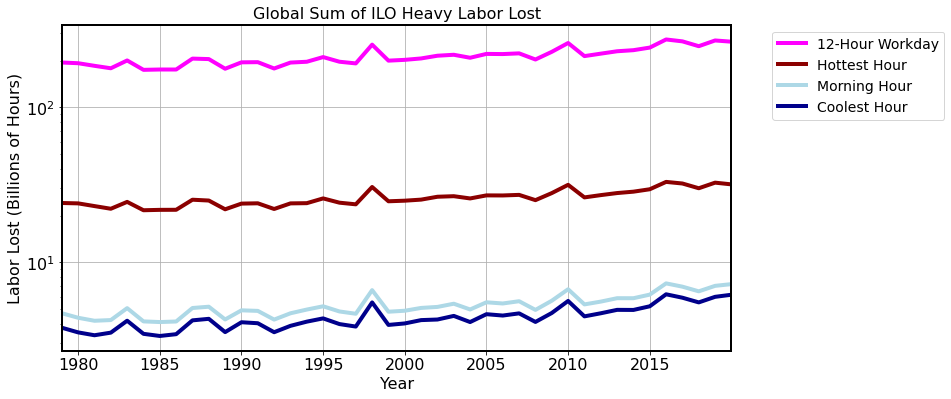

In [28]:
#plot for ILO heavy labor * working age pop (see earlier in code if it's ages 15+ like Kjellstrom, or 15-64 like other papers)
fig = plt.figure(figsize=(12,6))
#variables = ['minutes_24hr', 'minutes_maxmeanhalf','minutes_max','minutes_q0','minutes_q1','minutes_q2']

gwf = 0

ax = plt.subplot(1,1,1)

variable = 'minutes_maxmeanhalf'
plt.plot(Years,vars()['Global_Sum_ILO_HeavyLaborPop_'+str(variable)+'_gwf'+str(gwf)]/1e9*4,color='magenta',linewidth=4,label='12-Hour Workday')

variable = 'minutes_max'
plt.plot(Years,vars()['Global_Sum_ILO_HeavyLaborPop_'+str(variable)+'_gwf'+str(gwf)]/1e9,color='darkred',linewidth=4,label='Hottest Hour')

variable = 'minutes_q2'
plt.plot(Years,vars()['Global_Sum_ILO_HeavyLaborPop_'+str(variable)+'_gwf'+str(gwf)]/1e9,color='lightblue',linewidth=4,label='Morning Hour')

variable = 'minutes_q0'
plt.plot(Years,vars()['Global_Sum_ILO_HeavyLaborPop_'+str(variable)+'_gwf'+str(gwf)]/1e9,color='darkblue',linewidth=4,label='Coolest Hour')

plt.grid('True')
plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.xlabel('Year',fontsize=16)
plt.xticks(np.arange(1980,2020,5),fontsize=16)
plt.xlim(1979, 2020)
#plt.ylim(1200,3000)
plt.ylabel('Labor Lost (Billions of Hours)',fontsize=16)
plt.yticks([0.1,1,10,100,200],fontsize=16)
#ax.set_yscale('log')
#ax.set_yticks([0.1,1,10,100,200])
#ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.yscale('log')
plt.title('Global Sum of ILO Heavy Labor Lost',fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
#fig.savefig('TimeSeries_GlobalHeavyLaborLoss_1979_2020_FixedPopAt2017',dpi=300,bbox_inches='tight')

## concatenate the various gwfs for plotting all together

In [31]:

tas_era5_globalannualmean_gwf_all = np.concatenate(
                                                  (
                                                  np.squeeze(np.asarray(vars()['tas_era5_globalannualmean_gwf0'])),
                                                  np.squeeze(np.asarray(vars()['tas_era5_globalannualmean_gwf1'])),
                                                  np.squeeze(np.asarray(vars()['tas_era5_globalannualmean_gwf2'])),
                                                  np.squeeze(np.asarray(vars()['tas_era5_globalannualmean_gwf3'])),
                                                  np.squeeze(np.asarray(vars()['tas_era5_globalannualmean_gwf4']))
                                                  ),
                                                   axis = 0)

Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf_all = np.concatenate(
                                                  (
                                                  np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf0'],1e9)*4))),
                                                  np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf1'],1e9)*4))),
                                                  np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf2'],1e9)*4))),
                                                  np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf3'],1e9)*4))),
                                                  np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf4'],1e9)*4)))
                                                  ),
                                                   axis = 0)


## Now just the 12-hour workday labor lost (no economic impact)

(100.0, 1300.0)

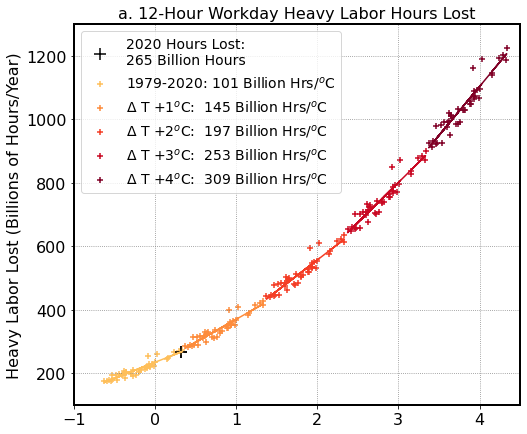

In [35]:
## PLOT 12-hour workday hours lost 
colors_lost = plt.cm.YlOrRd(np.linspace(0,1,2+len(gwfs)))

fsize = 16
fig = plt.figure(figsize=(8,7))
ax = plt.subplot(1,1,1)

gwf = 0
val_2020_labor = np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)*4)))[41]
plt.scatter(
    np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)]))[41],
    np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)*4)))[41],
    s = 150,
    marker = '+',
    color='black',
    label=str('2020 Hours Lost: \n'+str(int(round(val_2020_labor,0)))+' Billion Hours')
)

for gwf in gwfs:

    slope, intercept, r_value, p_value, std_err = stats.linregress(
        np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
        np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)*4)))
        )
    
    if gwf == 0:
        plt.scatter(
            np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
            np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)*4))),
            color=colors_lost[2+gwf,:],
            marker = '+',
            label=str('1979-2020: '+str(int(round(slope, 0)))+ ' Billion Hrs/$^o$C'))
    else:
        plt.scatter(
            np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
            np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)*4))),
            color=colors_lost[2+gwf,:],
            marker = '+',
            label=str('$\Delta$ T +'+str(gwf)+'$^o$C:  '+str(int(round(slope, 0)))+ ' Billion Hrs/$^o$C'))        
    
    m, b = np.polyfit(
        np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
        np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)*4))),
        1)
    
    plt.grid('True',color='gray', linestyle=':')
    plt.plot(np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
             m*np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])) + b,
             color=colors_lost[2+gwf,:])

gwf = 0

#re-plot cross over data
val_2020_labor = np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)*4)))[41]
plt.scatter(
    np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)]))[41],
    np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)*4)))[41],
    s = 150,
    marker = '+',
    color='black')

#plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left',)
#plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left',)
#plt.xlabel('Global-Mean Temperature Anomaly from 2001-2020 ($^o$C)',fontsize=fsize)
plt.ylabel('Heavy Labor Lost (Billions of Hours/Year)',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#    plt.title('12-Hour Work Day Hours Lost',fontsize=fsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.legend(fontsize=14, fancybox=True)
plt.title('a. 12-Hour Workday Heavy Labor Hours Lost',fontsize=fsize)

plt.xlim(-1,4.5)
plt.ylim(100,1300)

#fig.savefig('Figure3_Global_Sums_Labor_Lost_12hrWorkday_1979_2020_PlusWarming_1_2_3_4_C',dpi=300,bbox_inches='tight')

## Now just the coolest hour labor lost

(-1.0, 4.5)

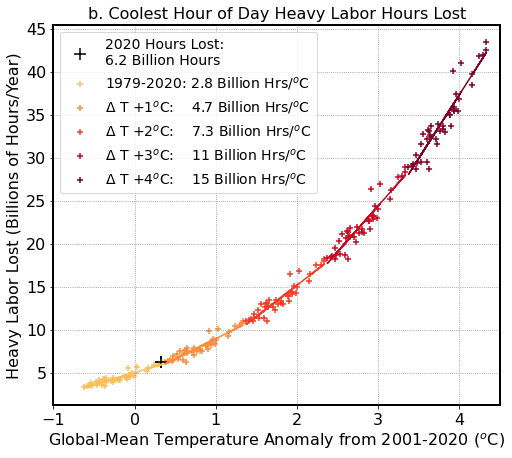

In [36]:
## Plot Sunrise hours lost only (coolest hour, or quantile 0: q0)

colors_lost = plt.cm.YlOrRd(np.linspace(0,1,2+len(gwfs)))

fsize = 16
fig = plt.figure(figsize=(8,7))
ax = plt.subplot(1,1,1)

gwf = 0
val_2020_labor = np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)],1e9))))[41]
plt.scatter(
    np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)]))[41],
    np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)],1e9))))[41],
    s = 150,
    marker = '+',
    color='black',
    label=str('2020 Hours Lost: \n'+str(round(val_2020_labor,1))+' Billion Hours')
)

for gwf in gwfs:

    slope, intercept, r_value, p_value, std_err = stats.linregress(
        np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
        np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)],1e9))))
        )
    
    if gwf == 0:
        plt.scatter(
            np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
            np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)],1e9)))),
            color=colors_lost[2+gwf,:],
            marker = '+',
            label=str('1979-2020: '+str(round(slope, 1))+ ' Billion Hrs/$^o$C'))
    else:
        if slope > 10:
            plt.scatter(
                np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
                np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)],1e9)))),
                color=colors_lost[2+gwf,:],
                marker = '+',
                label=str('$\Delta$ T +'+str(gwf)+'$^o$C:    '+str(int(round(slope, 0)))+ ' Billion Hrs/$^o$C'))
        else:
            plt.scatter(
                np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
                np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)],1e9)))),
                color=colors_lost[2+gwf,:],
                marker = '+',
                label=str('$\Delta$ T +'+str(gwf)+'$^o$C:    '+str(round(slope, 1))+ ' Billion Hrs/$^o$C'))
        
    m, b = np.polyfit(
        np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
        np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)],1e9)))),
        1)
    
    plt.grid('True',color='gray', linestyle=':')
    plt.plot(np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
             m*np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])) + b,
             color=colors_lost[2+gwf,:])
    plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left',)
#    plt.ylabel('ILO Heavy Labor Lost \n (Billions of Hours)',fontsize=fsize)
    plt.yticks(fontsize=fsize)
    plt.xticks(fontsize=fsize)
    #plt.xlabel('Global-mean, annual-mean t2m ($^o$C)',fontsize=fsize)
#    plt.title('12-Hour Work Day Hours Lost',fontsize=fsize)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

gwf = 0
#re-plot the cross over the other dots
val_2020_labor = np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)],1e9))))[41]
plt.scatter(
    np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)]))[41],
    np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)],1e9))))[41],
    s = 150,
    marker = '+',
    color='black',
)

plt.grid('True',color='gray', linestyle=':')
plt.ylabel('Heavy Labor Lost (Billions of Hours/Year)',fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlabel('Global-Mean Temperature Anomaly from 2001-2020 ($^o$C)',fontsize=fsize)
plt.title('b. Coolest Hour of Day Heavy Labor Hours Lost',fontsize=fsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
        
#plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.legend(fontsize=14, fancybox=True)
plt.xlim(-1,4.5)
#plt.ylim(0,1500)

#fig.savefig('Figure3_Global_Sums_Labor_Lost_CoolestHour_1979_2020_PlusWarming_1_2_3_4_C',dpi=300,bbox_inches='tight')

## now print out at the change in slope of regression line, etc at coolest hour


In [38]:
deltaT = 0,1,2,3,4

slopesq0 = np.zeros(len(gwfs))
r_valueq0 = np.zeros(len(gwfs))
std_errq0 = np.zeros(len(gwfs))

for gwf in gwfs:

    slopesq0[gwf], intercept, r_valueq0[gwf], p_value, std_errq0[gwf] = stats.linregress(
        np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
        np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_q0_gwf'+str(gwf)],1e9))))
        )
    print('for sunrise gwf ',gwf,'slope is:',slopesq0[gwf],'rsquared is:',r_valueq0[gwf]**2,' and std error is:',std_errq0[gwf])
    print('')

sunrisedeltaslope = slopesq0 - slopesq0[0]
sunrisedeltaslope_norm = sunrisedeltaslope/deltaT
sunrisedeltaslope_norm

for sunrise gwf  0 slope is: 2.849885001112475 rsquared is: 0.8748133289804683  and std error is: 0.17045851068254989

for sunrise gwf  1 slope is: 4.70205756909779 rsquared is: 0.877343776286048  and std error is: 0.27798274646064075

for sunrise gwf  2 slope is: 7.305137101169219 rsquared is: 0.8794914580494614  and std error is: 0.4275544967975356

for sunrise gwf  3 slope is: 10.698852869736356 rsquared is: 0.8812451546354934  and std error is: 0.6209898727771259

for sunrise gwf  4 slope is: 14.793395518338738 rsquared is: 0.8826221107157686  and std error is: 0.8529893710188821



array([       nan, 1.85217257, 2.22762605, 2.61632262, 2.98587763])

## now print out at the change in slope of regression line, etc for 12 hour workday


In [39]:
slopes12hr = np.zeros(len(gwfs))
r_value12hr = np.zeros(len(gwfs))
std_err12hr = np.zeros(len(gwfs))

for gwf in gwfs:

    slopes12hr[gwf], intercept, r_value12hr[gwf], p_value, std_err12hr[gwf] = stats.linregress(
        np.squeeze(np.asarray(vars()['tas_era5_globalannualmeananom_gwf'+str(gwf)])),
        np.squeeze(np.asarray((np.divide(vars()['Global_Sum_ILO_HeavyLaborPop_minutes_maxmeanhalf_gwf'+str(gwf)],1e9)*4)))
        )
    print('for gwf ',gwf,'slope is:',slopes12hr[gwf],'rsquared is:',r_value12hr[gwf]**2,' and std error is:',std_err12hr[gwf])
    print('')
    
    
fulldaydeltaslope = slopes12hr - slopes12hr[0]
fulldaydeltaslope_norm = fulldaydeltaslope/deltaT
fulldaydeltaslope_norm

for gwf  0 slope is: 101.18337199743776 rsquared is: 0.8907673531459157  and std error is: 5.60238867734296

for gwf  1 slope is: 144.9340926185137 rsquared is: 0.8925950286394628  and std error is: 7.94923837093555

for gwf  2 slope is: 196.5159233396095 rsquared is: 0.8940673931052846  and std error is: 10.69541036576416

for gwf  3 slope is: 252.62439107008686 rsquared is: 0.8951922994753638  and std error is: 13.667330971412174

for gwf  4 slope is: 308.5317557799475 rsquared is: 0.8959727030778215  and std error is: 16.622492382407238



array([        nan, 43.75072062, 47.66627567, 50.48033969, 51.83709595])